# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

## Objectives 

1. **Your primary objective is to develop an approach to detect the beginning of the “faulty” period**. Ideally, this approach would give the ExampleCo engineers as much time as possible to shut down their machines before failure occurs (at which time all measurements drop close to 0). The best solutions are automated in the sense that they would generalize to similar but slightly different data; simpler methods are acceptable but are less likely to receive full credit.
2. Demonstrate the efficacy of your approach using visualizations. You must also include a simple explanation of these figures and why your approach is effective, ideally written in language that non-technical executives could understand.
3. Finally, and now with a technical audience in mind, discuss the strengths and limitations of your approach and be sure to mention other approaches that you would have liked to try if you had more time.


## Notes to help
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. **Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted**. In particular, you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

# My solution

## Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
from ipywidgets import interact

%matplotlib inline

### Let's first look at the data for a single machine and do some EDA. The hope is that this will generalize to other machines

In [2]:
data = pd.read_csv('data/machine_0.csv',index_col=0)

data.head()

,0,1,2,3
2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


As expected there are 4 time-series data from sensors that appear to be taken at 8 hour intervals (based on the index of the dataframe)

In [7]:
data.describe()

,0,1,2,3
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.816016,-1.091308,1.267945,0.165844
std,58.078319,55.965665,56.538700,56.910659
min,-323.954437,-258.780879,-287.153920,-365.362164
25%,-0.008684,-0.008851,-0.008274,-0.007883
50%,-0.000402,-0.000085,0.000669,0.000310
75%,0.007832,0.008373,0.009056,0.008685
max,315.738951,264.374782,281.684102,340.513819


There are 3000 data points for this particular machine and no missing values. Now let's visualize this for each sensor

In [108]:
@interact
def plot_sensor_data(n=(0,3)):
    sensor = str(n)
    plt.plot(range(len(data)), data[sensor])
    plt.xlabel('Time step')
    plt.ylabel('Sensor value')
    plt.title('Sensor '+sensor)
    plt.show()

interactive(children=(IntSlider(value=1, description='n', max=3), Output()), _dom_classes=('widget-interact',)…

As we see, the data is quite spiky for all the sensors. This is probably due to the communications errors mentioned in the beginning. Let's try to deal with this first. We can start with a histogram

In [4]:
@interact
def plot_sensor_data_histogram(sensor=(0,3)):
    plt.hist(data[str(sensor)], bins=50)
    plt.ylabel('Count')
    plt.xlabel('Sensor value')
    plt.title('Sensor '+str(sensor))
    plt.show()

interactive(children=(IntSlider(value=1, description='sensor', max=3), Output()), _dom_classes=('widget-intera…

It is clear that the spike values are rare and much larger in magnitude than the actual data. The spike values are also quite symmetric. Let's dig deeper with a CDF plot of the absolute sensor value

In [5]:
@interact
def plot_sensor_data_cdf_diff(sensor=(0,3)):

    #get histogram, cdf, and "derivative"
    counts, bins = np.histogram(abs(data[str(sensor)]), bins=50)
    cdf = np.cumsum(counts)/len(data)
    values = (bins[:-1]+bins[1:])/2
    diff = cdf[1:]-cdf[:-1]
    ind = np.argmax(diff)

    #plot
    plt.plot(values, cdf)
    plt.plot(values[ind], cdf[ind], "ro")
    plt.ylabel('CDF')
    plt.xlabel('Sensor value magnitude')
    plt.title('Sensor '+str(sensor))
    plt.show()

interactive(children=(IntSlider(value=1, description='sensor', max=3), Output()), _dom_classes=('widget-intera…

We see that the outlier values can be identified by finding the maximum of the CDF derivative, as shown by the red dot. Note that they always seem to occur around 95th percentile. We can now get rid of the outlier values and replace them with a linear itnerpolation of the nearby values. 

In [6]:
@interact
def plot_sensor_data_remove_spikes(sensor=(0,3), percent=(2, 100)):

    #get histogram, cdf, and "derivative"
    y = data[str(sensor)].copy()
    counts, bins = np.histogram(abs(y), bins=50)
    cdf = np.cumsum(counts)/len(data)
    diff = cdf[1:]-cdf[:-1]
    ind = np.argmax(diff)
    cutoff = ((bins[:-1]+bins[1:])/2)[ind-1]

    # replace outlier values with nan
    cond = (abs(y) > cutoff)
    y[cond] = np.nan

    #plot
    plt.plot(range(len(y)), y.interpolate())
    plt.xlim(0, len(y)*percent/100)
    plt.ylabel('CDF')
    plt.ylabel('Sensor value')
    plt.xlabel('Time step')
    plt.title('Sensor '+str(sensor))
    plt.show()

interactive(children=(IntSlider(value=1, description='sensor', max=3), IntSlider(value=51, description='percen…

This is much better. Now let's remove the additional high frequency noise by taking a moving average

In [14]:
@interact
def plot_data_clean(percent=(2, 100), window=(1, 20)):

    #process data using the function denoise_data defined in utils.py
    clean_data = utils.denoise_data(data, window)

    #plot
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))

    for i in range(4):
        ax[i//2, i%2].plot(range(len(data)), clean_data[str(i)])
        ax[i//2, i%2].set_xlim(0, len(data)*percent/100)
        ax[i//2, i%2].set_xlabel('Time step')
        ax[i//2, i%2].set_title('Sensor '+str(i))
        
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=51, description='percent', min=2), IntSlider(value=10, description='wind…

We see that a window of around size 10 gives good results. <br />
At this stage it's clear that there are 3 modes of operation: *normal, faulty*, and *failed*. <br /> 
These seem to be characterized as follows:
* Normal mode: oscillatory with constant frequency and amplitude
* Faulty mode: oscillatory, but with highly varying amplitude/frequency
* Failed mode: near zero signal
<br /> <br />

Now, we need to build a model that can tell us the operating mode of the system. Since we do not have labelled data, we need to use some form of unsupervised learning first. <br />
One option is to take batches of the data and see how they relate to each other, say through some clustering approaches. Given the nature of the data we care about variations in frequency and aplitude over time. This suggests that a spectrogram would be a good representation.

# Spectrogram

In [14]:
from scipy import signal

In [57]:
clean_data = utils.denoise_data(data)

In [89]:
f, t, Sxx = signal.spectrogram(clean_data['1'], nperseg=64)

In [90]:
t

array([  32.,   88.,  144.,  200.,  256.,  312.,  368.,  424.,  480.,
        536.,  592.,  648.,  704.,  760.,  816.,  872.,  928.,  984.,
       1040., 1096., 1152., 1208., 1264., 1320., 1376., 1432., 1488.,
       1544., 1600., 1656., 1712., 1768., 1824., 1880., 1936., 1992.,
       2048., 2104., 2160., 2216., 2272., 2328., 2384., 2440., 2496.,
       2552., 2608., 2664., 2720., 2776., 2832., 2888., 2944.])

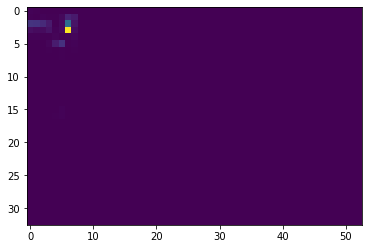

In [91]:
plt.imshow(Sxx, aspect="auto")

In [87]:
f.shape

(33,)